In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import pickle
import argparse
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import datetime
from pathlib import Path
import seaborn as sns
import time
from torch.utils.data import DataLoader
sys.path.insert(0, '..')
from config import *
import util.misc as utils
from util import box_ops
from util.xai import plot_matrix, get_cdna_slices, forward_func, collect_metrics_and_prediction, interpolate_expl_matrix, expl_matrix_treshold, gradcam, estimate_bbox
from models.nt_classifier import build as build_model
from dataset.data import (
    RNADatasetNT,
    EasyPosAugment,
    InteractionSelectionPolicy,
    SmartNegAugment,
    seed_everything,
)

from config import *

if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops10select_int4callERKNS_6TensorEll
  warn(f"Failed to load image Python extension: {e}")


In [3]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'df_nt_changed_fakeinteractionregions_and_couples_id_column') #'binary_cl2')

In [4]:
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
res = pd.read_csv(os.path.join(checkpoint_dir, 'test_results.csv'))
res['confidence'] = abs(res['probability'] - 0.5) + 0.5

#not in training pairs
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)

df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

not_in_train = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]

/tmp/ipykernel_247190/4050818113.py:2: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
/tmp/ipykernel_247190/4050818113.py:11: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))


In [5]:
CONFIDENCE_LEVEL = 0.6

query = not_in_train[(not_in_train.confidence>CONFIDENCE_LEVEL)]
print(f'acc overall: {np.round((query.ground_truth == query.prediction).sum()/query.shape[0], 2)}')
query = query[(query.ground_truth == 1)]
print(f'acc on positive task: {np.round((query.ground_truth == query.prediction).sum()/query.shape[0], 2)}')
query = query[(query.prediction == 1)]
print(f'I will try gradcam over {query.shape[0]} sequences')

acc overall: 0.68
acc on positive task: 0.34
I will try gradcam over 11 sequences


In [6]:
# Create df_nt_query

# df_nt_query = df_nt[df_nt.couples.isin(list(query.id_sample))]

query_id = query.g1+query.g2
df_nt_id = df_nt.gene1+df_nt.gene2
df_nt_query = df_nt[df_nt_id.isin(list(query_id))]

In [7]:
MAX_N_GROUP_SIZE = 300
DEVICE = 'cpu'

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'epoch31.pth') # best_model

df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))

pos_multipliers = {10_000_000:1.,}
neg_multipliers = pos_multipliers

policies_test = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]

dataset_test = RNADatasetNT(
    gene2info=df_genes_nt,
    interactions=df_nt_query,
    subset_file='',
    augment_policies=policies_test,
    data_dir = os.path.join(embedding_dir, '32'),
    scaling_factor = 5,
    min_n_groups = np.nan,
    max_n_groups = MAX_N_GROUP_SIZE,
)

sampler_test = torch.utils.data.SequentialSampler(dataset_test)

data_loader_test = DataLoader(dataset_test, 1,
                              sampler=sampler_test, drop_last=False,
                              collate_fn = utils.collate_fn_nt2,
                              num_workers=1)

device = torch.device(DEVICE)
model = build_model(args)
model.to(device)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.eval()

/tmp/ipykernel_247190/3834547494.py:14: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


BinaryClassifierNT(
  (nt_projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 0, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (top_classifier): MLP(
    (input_layer): Sequential(
      (0): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=5120, out_features=256, bias=True)
    )
    (hidden_layers): ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=True)
    )
    (output_layer): Linear(in_features=256, out_features=256, bias=True)
    (activation_functions): ModuleList(
      (0): Tanh()
      (1): ReLU()
    )
    (dropout_layers): ModuleList(
      (0-1): 2 x Dropout(p=0.01, inplace=False)
    )
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=1, stride=1, padding=

  0%|          | 0/11 [00:00<?, ?it/s]

tensor([0.6304], grad_fn=<SelectBackward0>)


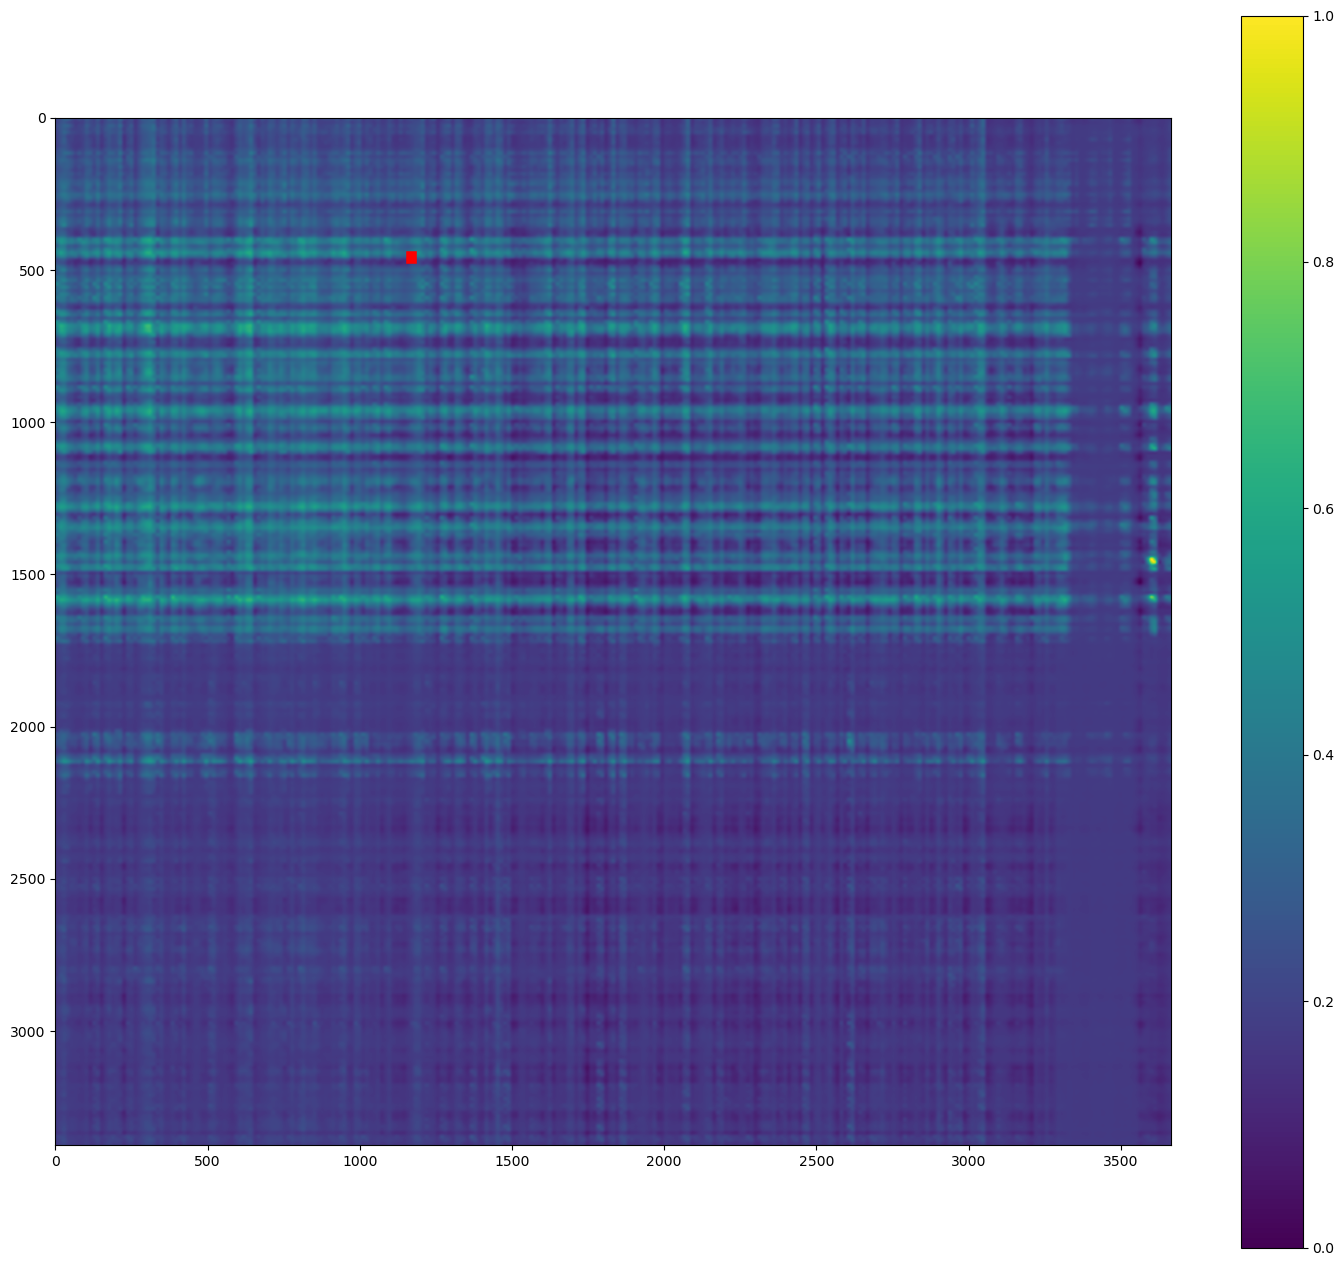

tensor([0.5302], grad_fn=<SelectBackward0>)


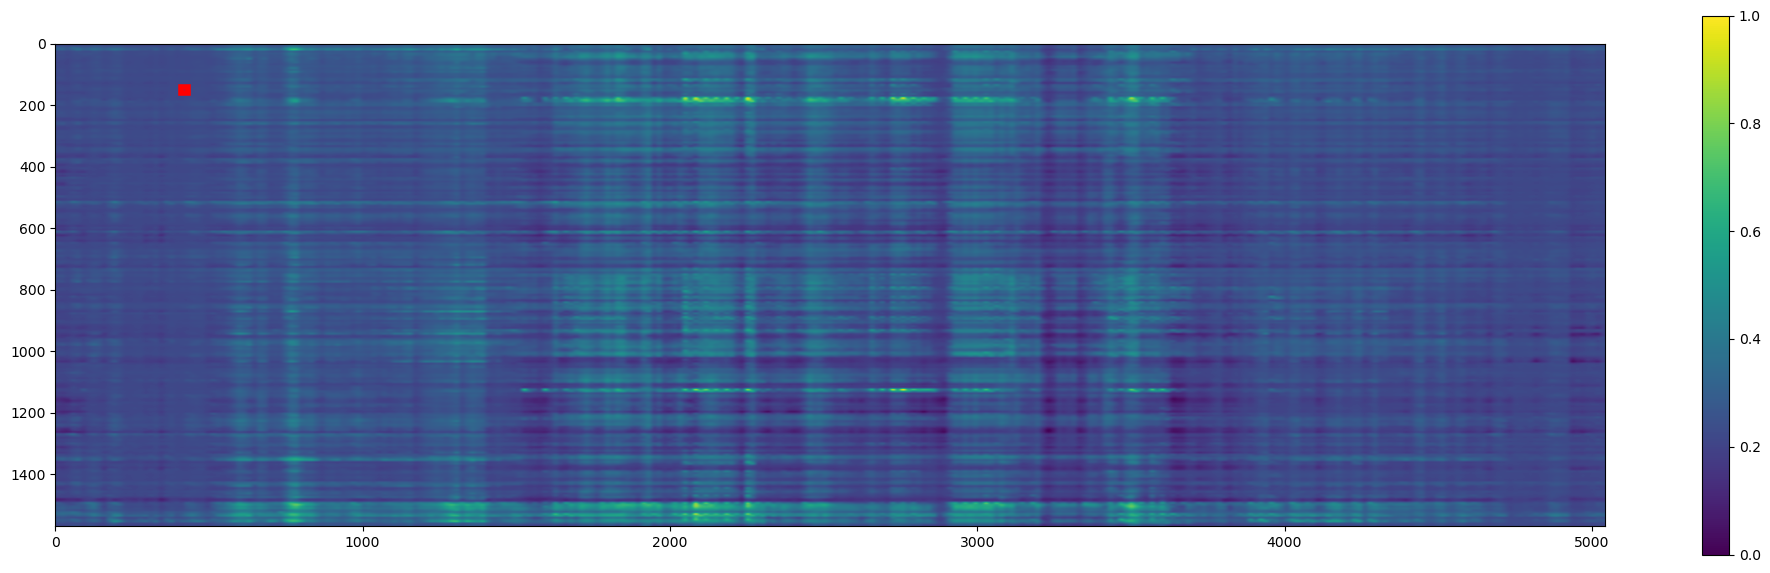

tensor([0.6848], grad_fn=<SelectBackward0>)


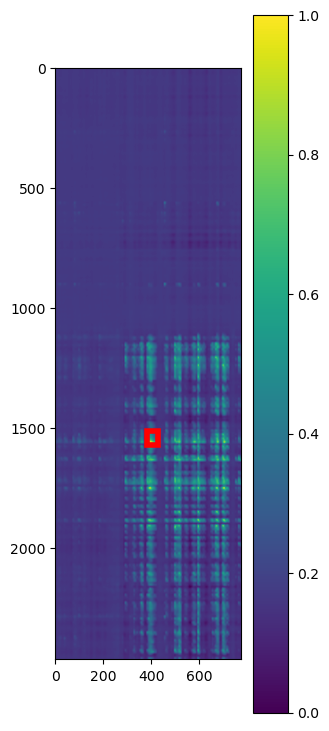

tensor([0.7739], grad_fn=<SelectBackward0>)


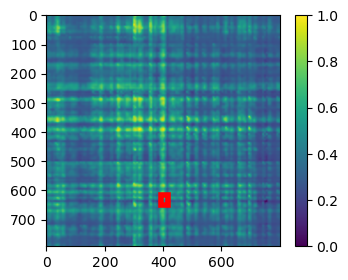

tensor([0.5306], grad_fn=<SelectBackward0>)


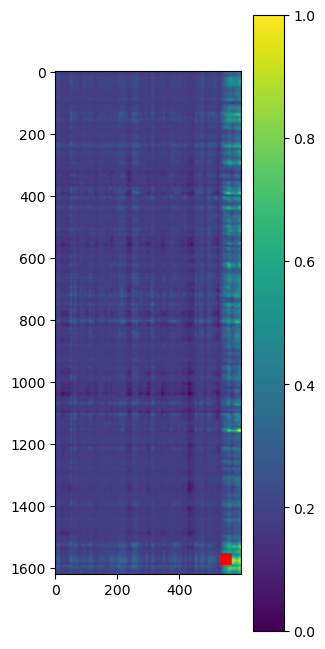

tensor([0.6954], grad_fn=<SelectBackward0>)


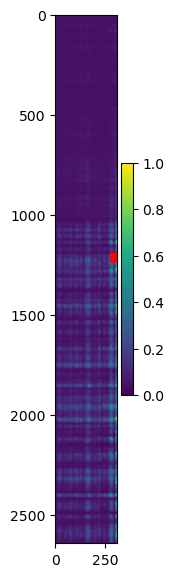

tensor([0.6320], grad_fn=<SelectBackward0>)


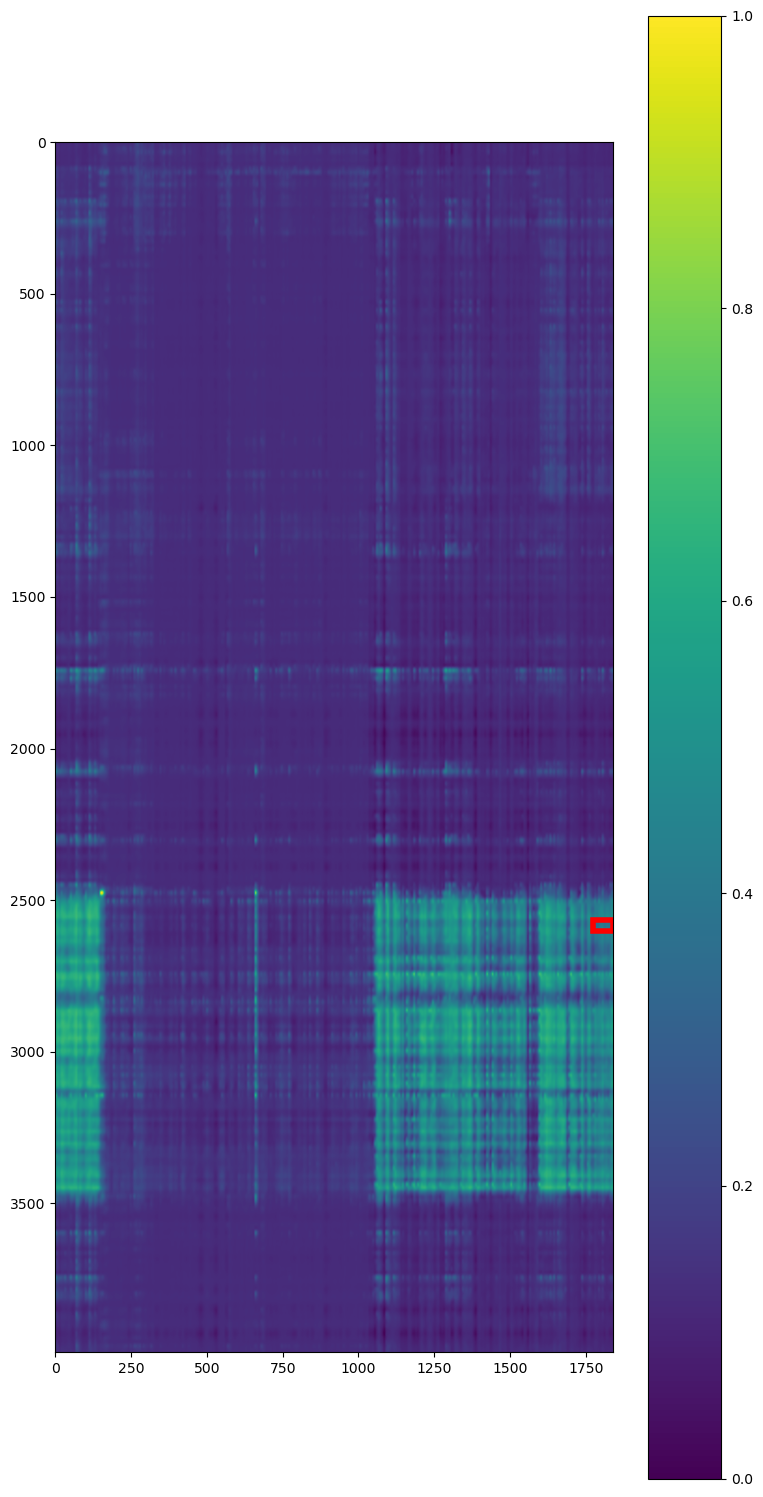

tensor([0.6104], grad_fn=<SelectBackward0>)


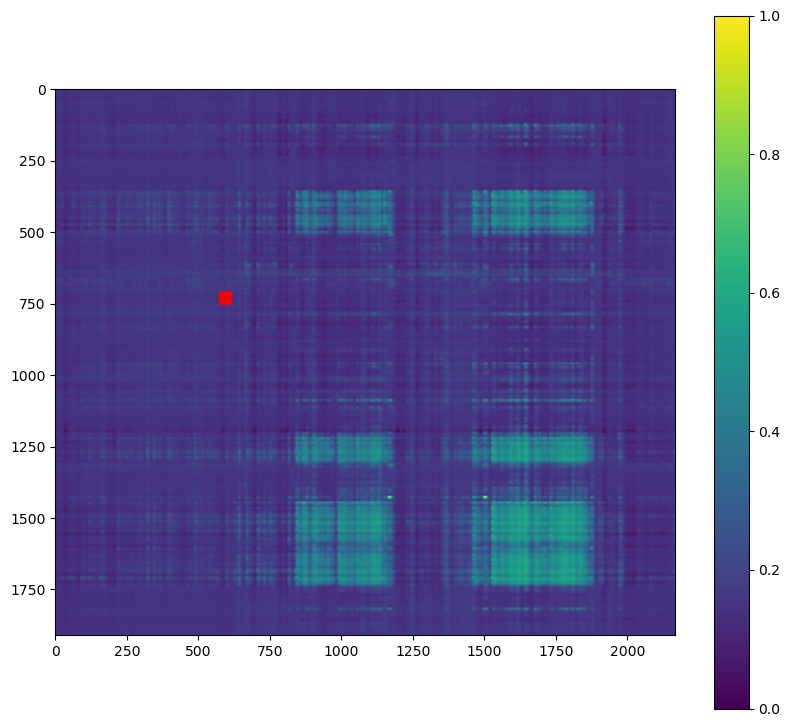

tensor([0.6276], grad_fn=<SelectBackward0>)


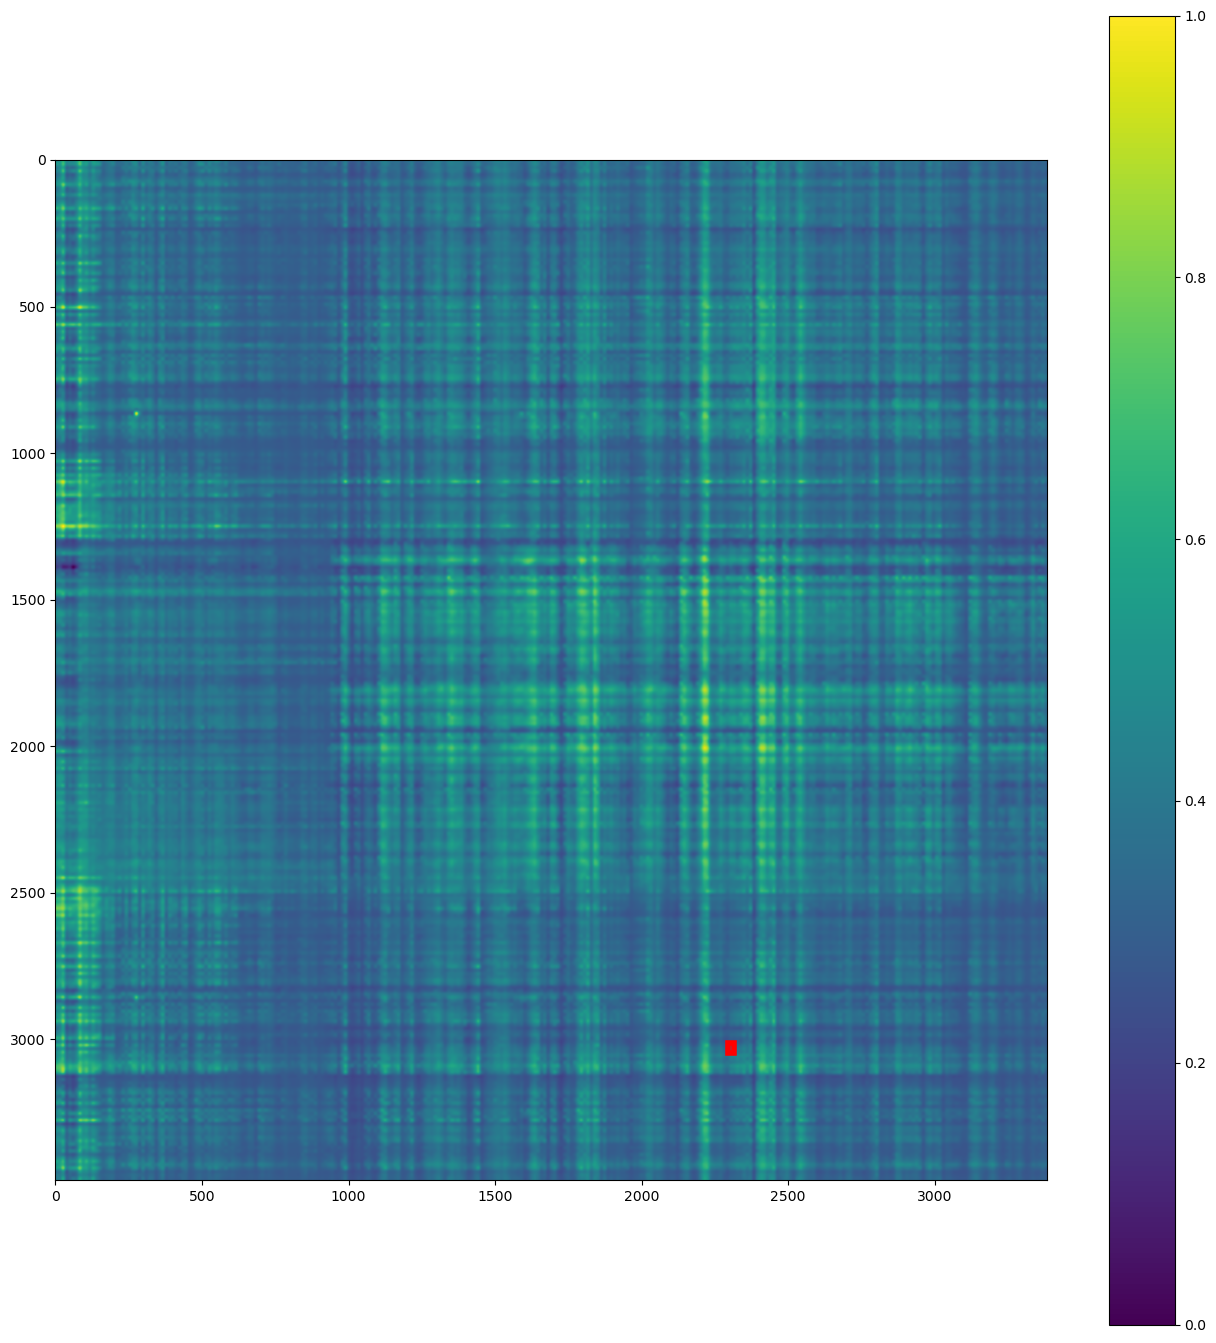

tensor([0.6074], grad_fn=<SelectBackward0>)


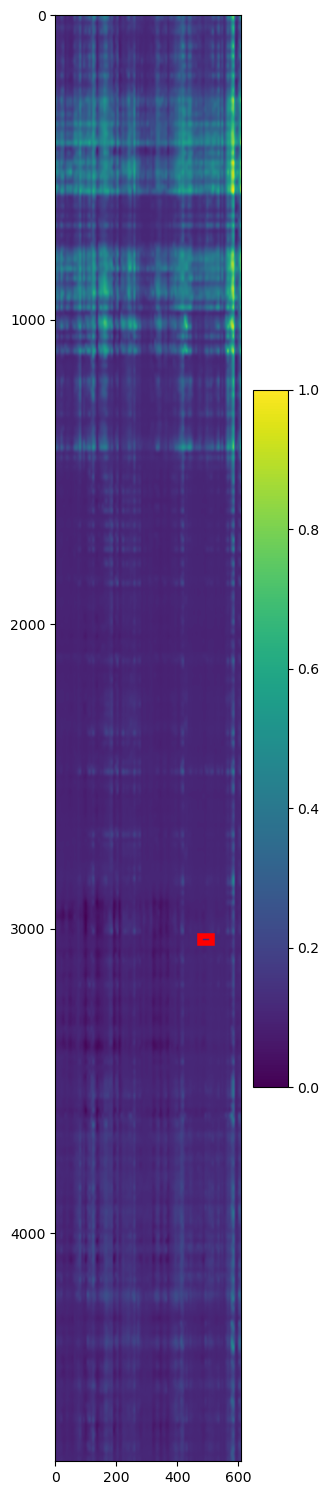

tensor([0.9681], grad_fn=<SelectBackward0>)


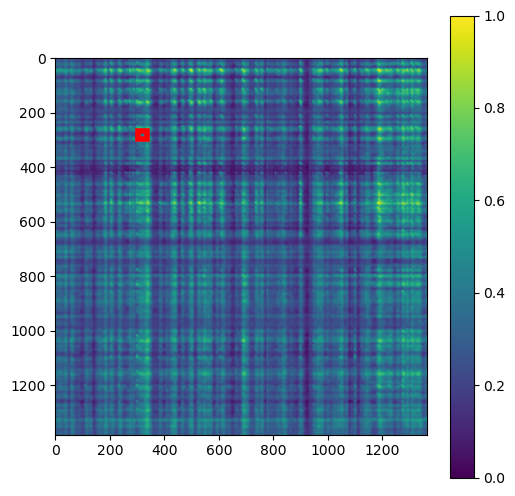

In [8]:
gradcam_results = []
treshold = 75

for (rna1, rna2), target in tqdm(data_loader_test):
    
    #rna1 = rna1[:, :, 150:] #drop it
    
    s = target[0]
    interacting = bool(s['interacting'])
    
    s_bbox = s['bbox']
    int_bbox = s['interaction_bbox']

    row_original = df_nt[(df_nt['gene1'] == s['gene1'])&(df_nt['gene2'] == s['gene2'])]
    row_swapped = df_nt[(df_nt['gene2'] == s['gene1'])&(df_nt['gene1'] == s['gene2'])]

    if len(row_original)>0:
        assert len(row_original) == 1
        row = row_original.iloc[0]
        
    elif len(row_swapped)>0:
        assert len(row_swapped) == 1
        row = row_swapped.iloc[0]
        
    else:
        raise NotImplementedError
        
    x1 = int(int_bbox.x1-s_bbox.x1)
    x2 = int(int_bbox.x2-s_bbox.x1)
    y1 = int(int_bbox.y1-s_bbox.y1)
    y2 = int(int_bbox.y2-s_bbox.y1)
    w = x2-x1
    h = y2-y1
    width = s_bbox.x2-s_bbox.x1
    height = s_bbox.y2-s_bbox.y1

    outputs = model(rna1.to(device), rna2.to(device))
    print(outputs.softmax(-1)[:, 1])
    outputs[:, 1].backward()
    
    expl_matrix = gradcam(model, rna1, rna2, counterfactual = False, cnn_layer = 2)

    expl_matrix_reshaped = interpolate_expl_matrix(expl_matrix, height, width)
    
    desired_dim = int(min(width, height) / 5)
    scaling_factor = 200

    cos_sim, iou_value, x1hat, y1hat, what, hhat, euclidean, euclidean_bbox, intensity = collect_metrics_and_prediction(expl_matrix_reshaped, x1, x2, y1, y2, desired_dim = desired_dim)
    
    
    expl_matrix_tr = expl_matrix_treshold(expl_matrix_reshaped, treshold = treshold, normalize = True)
    cos_sim_tr, iou_value_tr, x1hat_tr, y1hat_tr, what_tr, hhat_tr, euclidean_tr, euclidean_bbox_tr, intensity_tr = collect_metrics_and_prediction(expl_matrix_tr, x1, x2, y1, y2, desired_dim = desired_dim)

    
    random_expl_matrix = np.random.rand(expl_matrix_reshaped.shape[0], expl_matrix_reshaped.shape[1])
    cos_sim_rand, iou_value_rand, x1hat_rand, y1hat_rand, what_rand, hhat_rand, euclidean_rand, euclidean_bbox_rand, intensity_rand = collect_metrics_and_prediction(random_expl_matrix, x1, x2, y1, y2, desired_dim = desired_dim)
    
    gradcam_results.append(
         {"if": row.couples, 
          "probability": np.round(float(outputs.softmax(-1)[:, 1]), 3), 
          "iou_value":iou_value, 
          "iou_value_tr":iou_value_tr, 
          "iou_value_rand":iou_value_rand, 
          "cos_sim":cos_sim, 
          "cos_sim_tr":cos_sim_tr, 
          "cos_sim_rand":cos_sim_rand, 
          "euclidean":euclidean,
          "euclidean_tr":euclidean_tr,
          "euclidean_rand":euclidean_rand,
          "euclidean_bbox":euclidean_bbox,
          "euclidean_bbox_tr":euclidean_bbox_tr,
          "euclidean_bbox_rand":euclidean_bbox_rand,
          "intensity":intensity,
          "intensity_tr":intensity_tr,
          "intensity_rand":intensity_rand,
         }
     )
    
    plot_matrix(expl_matrix_reshaped, 
                ''.join(['C'for i in range(width)]), 
                ''.join(['C'for i in range(height)]), 
                [[x1, y1, w, h]], #crop_bbox =[x1hat, y1hat, what, hhat], 
                cmap ='viridis', 
                scaling_factor = scaling_factor,
    )
    plt.show()
        
gradcam_results = pd.DataFrame(gradcam_results)

### Read results

iou_value: 0.0027
iou_value_tr: 0.0027
iou_value_rand: 0.0


/tmp/ipykernel_247190/2767164898.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(gradcam_results[c], label = c)


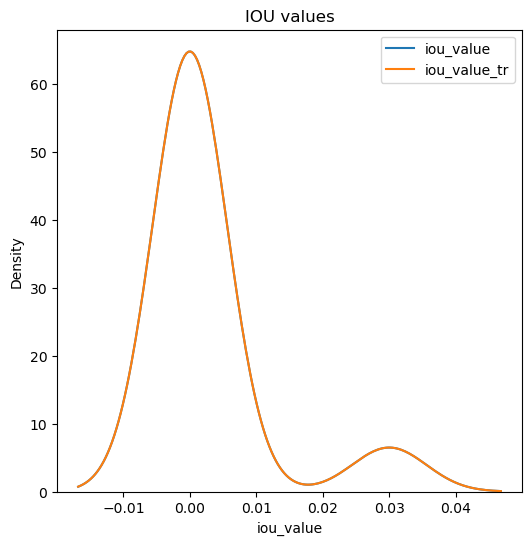

In [9]:
iou_columns = ['iou_value', 'iou_value_tr', 'iou_value_rand']
for c in iou_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'IOU values')
plt.legend()
plt.show()

cos_sim: 0.03
cos_sim_tr: 0.04
cos_sim_rand: 0.02


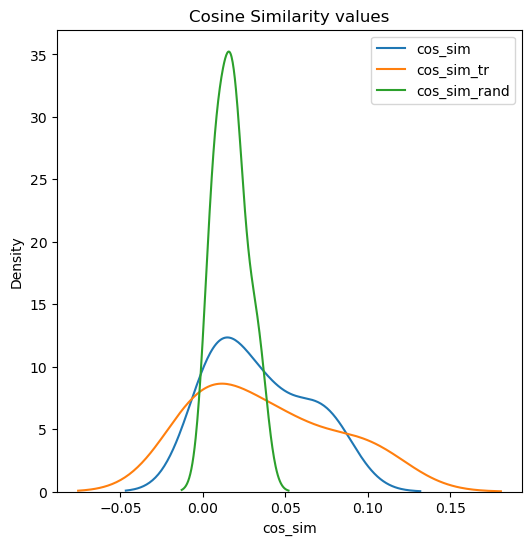

In [10]:
cosine_sim_columns = ['cos_sim', 'cos_sim_tr', 'cos_sim_rand']
for c in cosine_sim_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 2))}')

for c in cosine_sim_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Cosine Similarity values')
plt.legend()
plt.show()

euclidean: 0.5364
euclidean_rand: 0.5047
euclidean_bbox_tr: 0.3705


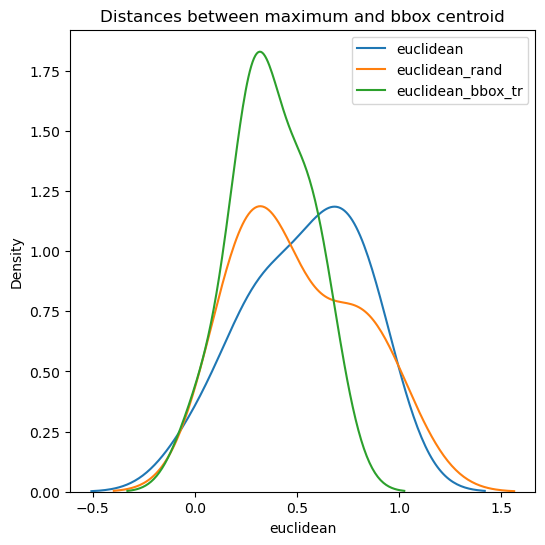

In [11]:
euclidean_columns = ['euclidean', 'euclidean_rand', 'euclidean_bbox_tr']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid')
plt.legend()
plt.show()

In [ ]:
intensity_columns = ['intensity', 'intensity_tr', 'intensity_rand']
for c in intensity_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
    
plt.title(f'Intensity of real_interaction_region')
plt.legend()
plt.show()